*Currently running with the "base" conda env, the "flc_local" env is giving me trouble*

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import xarray as xr
from scipy.spatial import cKDTree
import numpy as np

## Correlation between FLC Simulation and visibility

In [2]:
#--- Gulf Stream
latitude_north = 51
latitude_south = 30
longitude_west = -80
longitude_east = -55

In [3]:
flc_sim_path = "../../Downloads/north_atlantic_20240731.nc"
flc_ds = xr.open_dataset(flc_sim_path)

In [4]:
flc_ds

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 221)
Coordinates:
  * longitude  (longitude) float64 280.0 280.2 280.5 280.8 ... 334.5 334.8 335.0
  * latitude   (latitude) float64 61.0 60.75 60.5 60.25 ... 30.5 30.25 30.0
Data variables:
    BTD        (latitude, longitude) float64 ...

In [5]:
visibility_file_path = "../Maritime_Incidents_Data/ICOADS_R3.0.2_2024-07.nc"
visibility_ds = xr.open_dataset(visibility_file_path)
visibility_ds = visibility_ds.set_index(obs='time')

date = '2024-07-31'

filtered_ds = visibility_ds.sel(obs=slice(date+'T00:00:00', date+'T23:59:59.999999'))


In [6]:
vis_ds = filtered_ds.where(
    (filtered_ds['lat'] <= latitude_north) &
    (filtered_ds['lat'] >= latitude_south) &
    (filtered_ds['lon'] >= longitude_west+180) &
    (filtered_ds['lon'] <= longitude_east+180),
    drop=True
)

Nearest neighbors between the datasets:

In [7]:
# Extract latitude, longitude, and values from both datasets
flc_lat = flc_ds['latitude'].values
flc_lon = flc_ds['longitude'].values
flc_values = flc_ds['BTD'].values  # Replace 'values' with the actual variable name

vis_lat = vis_ds['lat'].values
vis_lon = vis_ds['lon'].values
vis_values = vis_ds['VV'].values  # Replace 'values' with the actual variable name

In [8]:
print(np.shape(flc_lat))
print(np.shape(flc_lon))
print(np.shape(flc_values))
print(np.shape(vis_lat))
print(np.shape(vis_lon))
print(np.shape(vis_values))

(125,)
(221,)
(125, 221)
(258,)
(258,)
(258,)


In [9]:
# Create a KDTree for the flc_ds grid points
flc_lon_grid, flc_lat_grid = np.meshgrid(flc_lon, flc_lat)
flc_coords = np.column_stack((flc_lat_grid.ravel(), flc_lon_grid.ravel()))
#flc_coords = np.column_stack((flc_lat.ravel(), flc_lon.ravel()))
tree = cKDTree(flc_coords)

# Find the nearest neighbor for each point in vis_ds
vis_coords = np.column_stack((vis_lat, vis_lon))
distances, indices = tree.query(vis_coords)

# Get the corresponding flc_ds values
flc_nearest_values = flc_values.ravel()[indices]

In [10]:
np.max(flc_values)

36.0700992347918

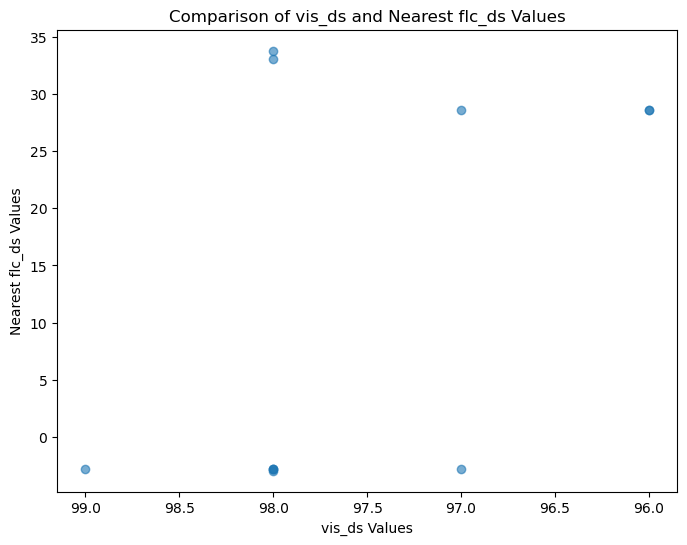

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(vis_values, flc_nearest_values, alpha=0.6)
plt.gca().invert_xaxis()
plt.xlabel('vis_ds Values')
plt.ylabel('Nearest flc_ds Values')
plt.title('Comparison of vis_ds and Nearest flc_ds Values')
plt.show()